In [145]:
import pandas as pd
import jax.numpy as jnp
import jax
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando o dataset wine diretamente do scikit-learn
from sklearn.datasets import load_wine
data, target = load_wine(return_X_y=True, as_frame=True)

eval_dict = {
    'Accuracy' : accuracy_score,
    'MC Coef' : matthews_corrcoef,
    'Confusion Matrix' : confusion_matrix,
    'F1 Score' : f1_score,
    'Recall' : recall_score,
}

print(data.shape)

data.head()

(178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [146]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.4, random_state=166003)

compact_data = (x_train, x_test, y_train, y_test )

jx_train, jx_test, jy_train, jy_test = jnp.array(x_train), jnp.array(x_test) , jnp.array(y_train), jnp.array(y_test)

x_train.shape, x_test.shape, y_train.shape, y_test.shape


((106, 13), (72, 13), (106,), (72,))

Accuracy : 0.8333
MC Coef : 0.7539
F1 Score : 0.8333
Recall : 0.8333


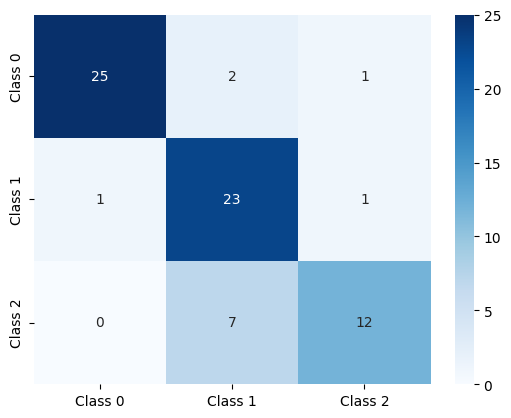

In [147]:
def get_metrics(preds, ytest, eval_metrics):

    results = {}

    for m_name, m_foo in eval_metrics.items():
        if m_name in ['F1 Score', 'Recall'] :
            results[m_name] = m_foo(ytest, preds, average='micro')
        else:
            results[m_name] = m_foo(ytest, preds)

    return results

def show_results(results):
    
    for m_name, m_value in results.items():

        if m_name == 'Confusion Matrix': 

            sns.heatmap(m_value, annot=True, fmt="d", cmap="Blues", cbar=True, 
                xticklabels=["Class 0", "Class 1", "Class 2"], 
                yticklabels=["Class 0", "Class 1", "Class 2"])

        else:
            print(f'{m_name} : {m_value:.4f}')



def run_sklearn_benchmark(data, eval_metrics, k=5, metric='minkowski'): 

    x_train, x_test, y_train, y_test = data

    knn_benchmark = KNeighborsClassifier(n_neighbors=k, metric=metric)

    knn_benchmark.fit(x_train, y_train)

    y_pred = knn_benchmark.predict(x_test)

    results = get_metrics(y_pred, y_test, eval_metrics)


    return results



results = run_sklearn_benchmark(compact_data, eval_dict, k=1)

show_results(results)


### Defining a distance function

Given any dot product  $<. \hspace{5px},\hspace{5px} .>$ this distance between two vectors X, Y is equal to :

$$ d(X,Y) =  ||X, Y || = (<X- Y,X - Y>)^\frac{1}{2}$$



In [317]:
x = jnp.array([3,5])
y = jnp.array([6,9])

a1 = jx_test[0]
a2 = jx_train[1]

x_long = jnp.repeat(jnp.array([x]), 4, axis=0)
y_long = jnp.repeat(jnp.array([y]), 2, axis=0)



def r2_inner_product(a, b):
    # inner product implemented at the book (eq 3.9)
    return a[0] * b[0] -(a[0] * b[1] + a[1] * b[0]) +  2 * a[1] * b[1]


def generic_distance(x, y, inner_product=jnp.dot):
    # TODO: fixing JIT for generic distance
    return jnp.sqrt(inner_product(x - y, x - y))



def batch_generic_distance(X, Y, inner_product = jnp.dot):
    '''
    calculates the distance matrix for two N, M arrays
    '''
    def __one_vector_to_Nvector(xi, vec, inner_product):

        return jax.vmap(lambda yi : generic_distance(xi, yi, inner_product))(vec)
    
    d_matrix = jax.vmap(lambda xi : __one_vector_to_Nvector(xi, Y, inner_product))(X)

    print(__one_vector_to_Nvector(X[1], Y, inner_product))


    print(X.T, '\n','\n',Y.T)
    print()
    print(d_matrix)



batch_generic_distance(x_long, y_long)



[5. 5.]
[[3 3 3 3]
 [5 5 5 5]] 
 
 [[6 6]
 [9 9]]

[[5. 5.]
 [5. 5.]
 [5. 5.]
 [5. 5.]]
